# Initialize

In [1]:
from maze import Maze
import tester
import ipywidgets as widgets
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import algos
import seaborn as sns


In [2]:
%matplotlib widget
CELL_SIZE = 20
sns.set_style("darkgrid")

In [3]:
def get_maze_img(maze, color=(0, 0, 0)):
    cell_size = CELL_SIZE
    dim = len(maze)
    img = np.ones((dim*cell_size+1+20,dim*cell_size+1,3), dtype=np.uint8)*255
    dir_int = {'u': 1, 'r': 2, 'd': 4, 'l': 8}
    # plt.figure(figsize=(7,7))
    # plt.axis(False)
    for x in range(dim):
        for y in range(dim):
            # cv2.rectangle(img, (x*cell_size,y*cell_size), ((x+1)*cell_size,(y+1)*cell_size), (0,0,0), 1)
            if not maze[x][y] & dir_int['u']:
                cv2.line(img, (cell_size * x, cell_size * (y+1)), (cell_size * (x+1), cell_size * (y+1)), color, 1)
            if not maze[x][y] & dir_int['r']:
                cv2.line(img, (cell_size * (x+1), cell_size * y), (cell_size * (x+1), cell_size * (y+1)), color, 1)
            if not maze[x][y] & dir_int['d']:
                cv2.line(img, (cell_size * x, cell_size * y), (cell_size * (x+1), cell_size * y), color, 1)
            if not maze[x][y] & dir_int['l']:
                cv2.line(img, (cell_size * x, cell_size * y), (cell_size * x, cell_size * (y+1)), color, 1)

    return img


In [4]:
def draw_maze(maze):
    img = get_maze_img(maze)
    plt.figure(figsize=(7,7))
    plt.axis(False)
    plt.imshow(img, origin='lower') # show the image


In [6]:
def flip_img(img):
    img2 = img.copy()
    for i in range(len(img)):
        img2[i] = img[len(img) - 1 - i]
    return img2

In [5]:
dir_sensors = {'u': ['l', 'u', 'r'], 'r': ['u', 'r', 'd'],
               'd': ['r', 'd', 'l'], 'l': ['d', 'l', 'u'],
               'up': ['l', 'u', 'r'], 'right': ['u', 'r', 'd'],
               'down': ['r', 'd', 'l'], 'left': ['d', 'l', 'u']}
dir_move = {'u': [0, 1], 'r': [1, 0], 'd': [0, -1], 'l': [-1, 0],
            'up': [0, 1], 'right': [1, 0], 'down': [0, -1], 'left': [-1, 0]}
dir_reverse = {'u': 'd', 'r': 'l', 'd': 'u', 'l': 'r',
               'up': 'd', 'right': 'l', 'down': 'u', 'left': 'r'}
max_time = 1000
train_score_mult = 1/30.
verbose = False

def test_maze(maze, algo):
        # Create a maze based on input argument on command line.
    result = dict()
    testmaze = maze

    # Intitialize a robot; robot receives info about maze dimensions.
    testrobot = algo(testmaze.dim)

    # Record robot performance over two runs.
    runtimes = []
    total_time = 0
    for run in range(2):
        if verbose:
            print(("Starting run {}.".format(run)))

        # Set the robot in the start position. Note that robot position
        # parameters are independent of the robot itself.
        robot_pos = {'location': [0, 0], 'heading': 'up'}

        run_active = True
        hit_goal = False
        while run_active:
            # check for end of time
            total_time += 1
            if total_time > max_time:
                run_active = False
                if verbose:
                    print ("Allotted time exceeded.")
                result[f'run{run}'] = total_time
                break

            # provide robot with sensor information, get actions
            sensing = [testmaze.dist_to_wall(robot_pos['location'], heading)
                       for heading in dir_sensors[robot_pos['heading']]]
            rotation, movement = testrobot.next_move(sensing)

            # check for a reset
            if (rotation, movement) == ('Reset', 'Reset'):
                if run == 0 and hit_goal:
                    run_active = False
                    runtimes.append(total_time)
                    if verbose:
                        print ("Ending first run. Starting next run.")
                    result[f'run{run}'] = total_time
                    break
                elif run == 0 and not hit_goal:
                    if verbose:
                        print ("Cannot reset - robot has not hit goal yet.")
                    continue
                else:
                    if verbose:
                        print ("Cannot reset on runs after the first.")
                    continue

            # perform rotation
            if rotation == -90:
                robot_pos['heading'] = dir_sensors[robot_pos['heading']][0]
            elif rotation == 90:
                robot_pos['heading'] = dir_sensors[robot_pos['heading']][2]
            elif rotation == 0:
                pass
            else:
                if verbose:
                    print ("Invalid rotation value, no rotation performed.")

            # perform movement
            if abs(movement) > 3:
                if verbose:
                    print ("Movement limited to three squares in a turn.")
            movement = max(min(int(movement), 3), -3) # fix to range [-3, 3]
            while movement:
                if movement > 0:
                    if testmaze.is_permissible(robot_pos['location'], robot_pos['heading']):
                        robot_pos['location'][0] += dir_move[robot_pos['heading']][0]
                        robot_pos['location'][1] += dir_move[robot_pos['heading']][1]
                        movement -= 1
                    else:
                        if verbose:
                            print ("Movement stopped by wall.")
                        movement = 0
                else:
                    rev_heading = dir_reverse[robot_pos['heading']]
                    if testmaze.is_permissible(robot_pos['location'], rev_heading):
                        robot_pos['location'][0] += dir_move[rev_heading][0]
                        robot_pos['location'][1] += dir_move[rev_heading][1]
                        movement += 1
                    else:
                        if verbose:
                            print ("Movement stopped by wall.")
                        movement = 0

            # check for goal entered
            goal_bounds = [testmaze.dim/2 - 1, testmaze.dim/2]
            if robot_pos['location'][0] in goal_bounds and robot_pos['location'][1] in goal_bounds:
                hit_goal = True
                if run != 0:
                    runtimes.append(total_time - sum(runtimes))
                    run_active = False
                    if verbose:
                        print(("Goal found; run {} completed!".format(run)))

    # Report score if robot is successful.
    if len(runtimes) == 2:
        if verbose:
            print(("Task complete! Score: {:4.3f}".format(runtimes[1] + train_score_mult*runtimes[0])))
        result['run1'] = total_time - result['run0']
        result['score'] = runtimes[1] + train_score_mult*runtimes[0]
        result['success'] = hit_goal
    
    result['robot'] = testrobot
    return result

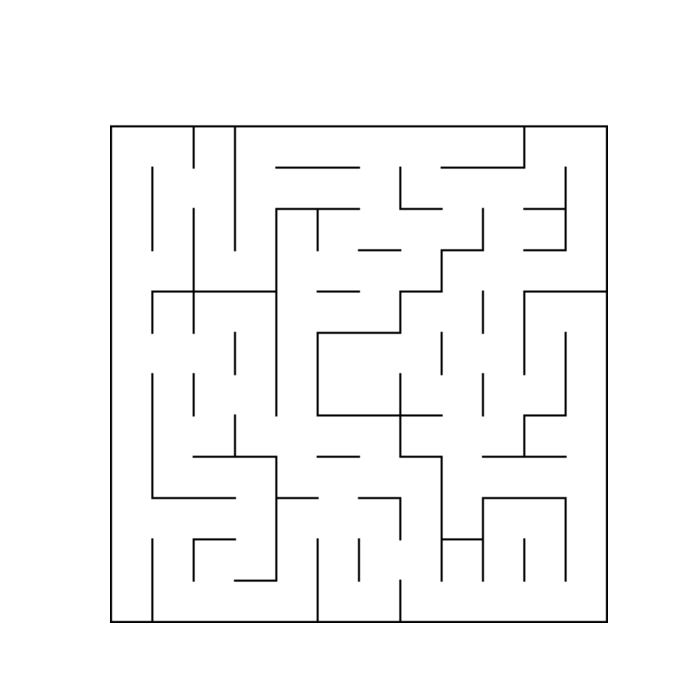

In [49]:
maze = Maze('mazes/test_maze_01.txt')
draw_maze(maze.walls)

# Run algorithm

In [7]:
# algo = algos.DFS
# algo = algos.BestFirst
# algo = algos.Dijkstra
# algo = algos.FloodFill
algo = algos.FloodFillExploratory

# verbose = True
verbose = False
maze = Maze('mazes/test_maze_01.txt')
result = test_maze(maze, algo)
journey = result['robot'].journey
print(result)


{'run0': 189, 'run1': 30, 'score': 36.3, 'success': True, 'robot': <algos.FloodFillExploratory object at 0x7f38eca818d0>}


# Visualize

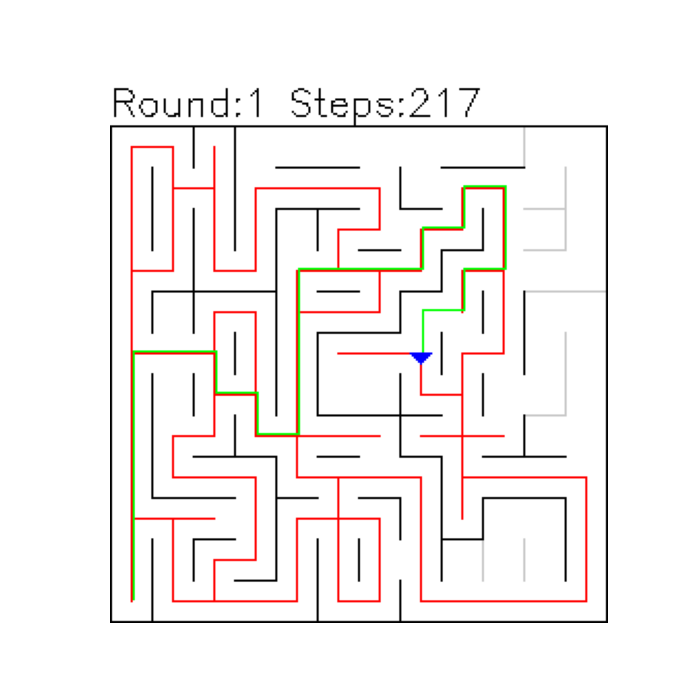

In [8]:
images = list()
base_img = get_maze_img(maze.walls, color=(200, 200, 200))
cell_size = CELL_SIZE
mid = cell_size // 2
color = {0: (255, 0, 0), 1:(0, 255, 0)}
round = 0
floodfill = False
for i in range(1, len(journey)):
    img = get_maze_img(journey[i][1]) & base_img
    images.append(img)

for i in range(len(images)):
    x0,y0 = journey[i][0]
    x1,y1 = journey[i+1][0]
    img = images[i]
    if journey[i][2] == journey[i+1][2]:
        for j in range(i, len(images)):
            cv2.line(images[j], (mid + journey[i][2] + cell_size * x0, mid + journey[i][2] + cell_size * y0), (mid + journey[i][2] + cell_size * x1, mid + journey[i][2] + cell_size * y1), color[journey[i][2]], 1)
        mid_pos = (mid + cell_size * x1, mid + cell_size * y1)
        rot = ((x1 - x0), (y1 - y0))
        triangle_cnt = [(mid_pos[0] + rot[1] * 5, mid_pos[1] + rot[0] * 5), (mid_pos[0] + rot[0] * 5, mid_pos[1] + rot[1] * 5), (mid_pos[0] - rot[1] * 5, mid_pos[1] - rot[0] * 5)]
        cv2.drawContours(img, [np.array(triangle_cnt)], 0, (0, 0, 255), -1)
    else:
        round += 1
    # cv2.circle(img, (mid + cell_size * x1, mid + cell_size * y1), cell_size // 2, (0,0,255))
    img = flip_img(img)
    cv2.putText(img, f'Round:{round} Steps:{i}', (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 1)
    images[i] = img
    

plt.figure(figsize=(7,7))
plt.axis(False)
plt.imshow(img)

# Show steps

interactive(children=(IntSlider(value=0, description='steps', max=217), Output()), _dom_classes=('widget-inter…

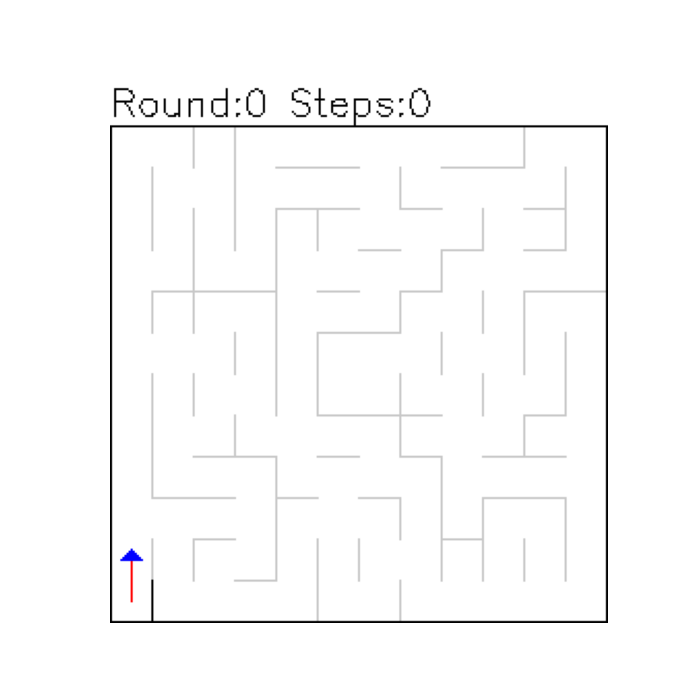

In [9]:
def update(steps=0):
    img = images[steps]
    plt.imshow(img)

fig =plt.figure(figsize=(7,7))
plt.axis(False)

widgets.interact(update, steps=widgets.IntSlider(min=0,max=len(images)-1,step=1,value=0));

# Save images

In [36]:
def save_images(i):
    plt.imshow(images[i])
    plt.savefig(f'images/image{i:03d}.png')

In [49]:
results = list()
with mp.Pool(processes=48) as p:
    list(tqdm(p.imap_unordered(save_images, range(len(images))), total=len(images)))

  0%|          | 0/218 [00:00<?, ?it/s]

# Run all algorithms

In [10]:
import pandas as pd
import multiprocessing as mp
from tqdm.auto import tqdm

In [15]:
mazes = [os.path.join('mazes',x) for x in os.listdir('mazes')]
algos = [
         algos.DFS,
         algos.BestFirst,
         algos.Dijkstra,
         algos.FloodFill,
         algos.FloodFillExploratory
        ]

In [16]:
def run_algos(maze_name):
    results = list()
    maze = Maze(maze_name)
    for algo in algos:
        res = dict()
        ALGORITHM = algo
        try:
            res |= test_maze(maze, algo)
        except:
            pass
        res['algo'] = algo.__name__
        res['maze'] = maze_name
        results.append(res)
    return results

In [19]:
results = list()
with mp.Pool(processes=mp.cpu_count()) as p:
    for res in tqdm(p.imap_unordered(run_algos, mazes), total=len(mazes)):
        results += res

  0%|          | 0/411 [00:00<?, ?it/s]

In [20]:
df = pd.DataFrame(results)
df

,run0,run1,score,success,robot,algo,maze
0,253.0,252.0,260.433333,True,<algos.DFS object at 0x7f3c1f3e5300>,DFS,mazes/empty.maz
1,15.0,14.0,14.500000,True,<algos.BestFirst object at 0x7f3c1f3e6680>,BestFirst,mazes/empty.maz
2,256.0,15.0,23.533333,True,<algos.Dijkstra object at 0x7f3c1f3e6020>,Dijkstra,mazes/empty.maz
3,31.0,14.0,15.033333,True,<algos.FloodFill object at 0x7f3c1f3e6440>,FloodFill,mazes/empty.maz
4,29.0,14.0,14.966667,True,<algos.FloodFillExploratory object at 0x7f3c1f...,FloodFillExploratory,mazes/empty.maz
...,...,...,...,...,...,...,...
2050,NaN,NaN,NaN,NaN,NaN,DFS,mazes/5x5_test2.maz
2051,NaN,NaN,NaN,NaN,NaN,BestFirst,mazes/5x5_test2.maz
2052,NaN,NaN,NaN,NaN,NaN,Dijkstra,mazes/5x5_test2.maz
2053,1001.0,1002.0,NaN,NaN,<algos.FloodFill object at 0x7f3c0e095150>,FloodFill,mazes/5x5_test2.maz


In [21]:
del df['robot']

In [22]:
df.to_parquet('results/maze_results.parquet')

# Clean results

In [25]:
df = pd.read_parquet('results/maze_results.parquet')
df.shape

(2055, 6)

In [26]:
df.loc[df.isna().any(axis=1)]['maze'].value_counts()

mazes/5x5_test1.maz            5
mazes/map-y77.maz              5
mazes/minimaze.maz             5
mazes/5x5_test4.maz            5
mazes/maze-train-10x5.maz      5
mazes/5x5_test3.maz            5
mazes/map-y7.maz               5
mazes/maze-train-10x5-a.maz    5
mazes/maze-train-10x5-q.maz    5
mazes/5x5_test2.maz            5
Name: maze, dtype: int64

In [27]:
df.dropna(inplace=True)
df.shape

(2005, 6)

In [28]:
df['success'].value_counts()

True    2005
Name: success, dtype: int64

In [29]:
del df['success']

In [30]:
df.rename(columns={'run0':'explore', 'run1':'navigate'}, inplace=True)

In [31]:
df.to_parquet('results/maze_results_cleaned.parquet')

# Analyze results

In [32]:
df = pd.read_parquet('results/maze_results_cleaned.parquet')

In [33]:
df['maze'].nunique()

401

In [36]:
df_test1 = df[['explore','navigate','score','algo']].loc[df['maze'] == 'mazes/test_maze_01.txt'].copy().set_index('algo', drop=True).sort_values('score')
df_test1

,explore,navigate,score
algo,,,
FloodFillExploratory,189.0,30.0,36.300000
FloodFill,92.0,34.0,37.066667
Dijkstra,293.0,30.0,39.766667
BestFirst,72.0,46.0,48.400000
DFS,252.0,42.0,50.400000


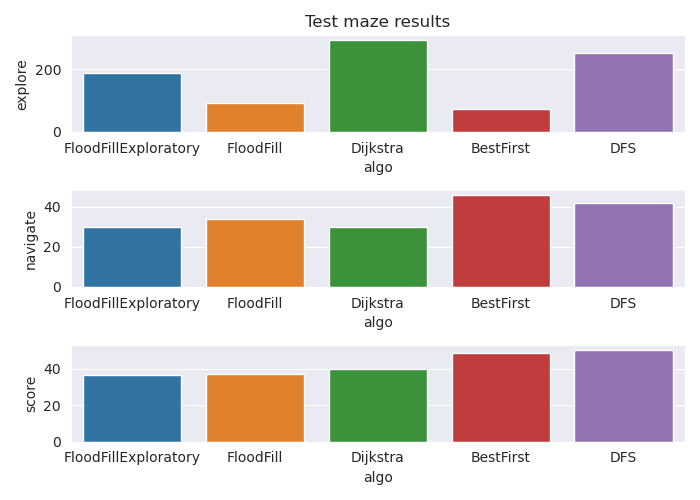

In [59]:
fig, axes = plt.subplots(nrows=3, figsize=(7,5))

for cur_ax, feature in zip(axes, ['explore', 'navigate', 'score']):
    sns.barplot(df_test1, x=df_test1.index, y=feature, ax=cur_ax)

axes[0].set_title('Test maze results')
fig.tight_layout()
plt.savefig('images/test_maze_01_results.png')

In [38]:
df_res = df.groupby('algo')[['explore', 'navigate', 'score']].mean().sort_values('score')
df_res

,explore,navigate,score
algo,,,
FloodFillExploratory,267.850374,59.506234,68.434580
FloodFill,207.468828,68.192020,75.107648
Dijkstra,492.578554,65.578554,81.997839
BestFirst,177.471322,78.488778,84.404489
DFS,265.316708,90.967581,99.811471


In [39]:
metrics = df.groupby('maze').agg({col:['min', 'median', 'max'] for col in ['explore', 'navigate', 'score']}).mean()
df_metrics = pd.DataFrame(metrics).unstack(level=1).T
df_metrics.index = df_metrics.index.droplevel(level=0)
df_metrics

,explore,navigate,score
min,142.855362,58.556110,66.539318
median,251.910224,67.528678,78.023192
max,494.249377,97.563591,106.871987


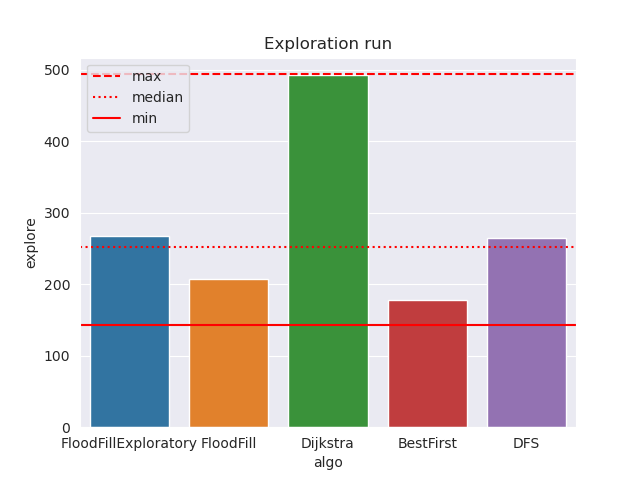

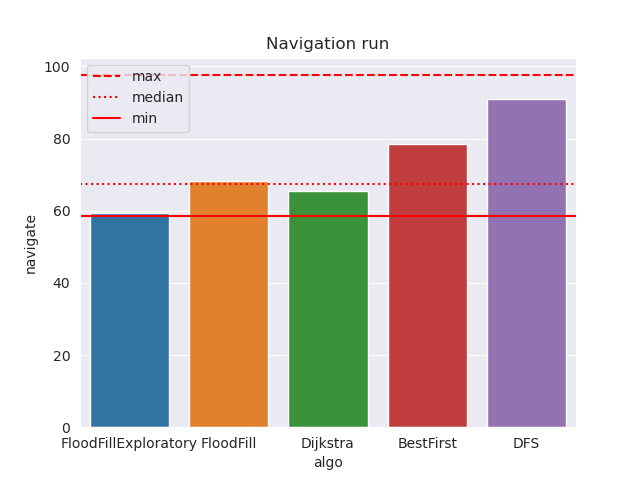

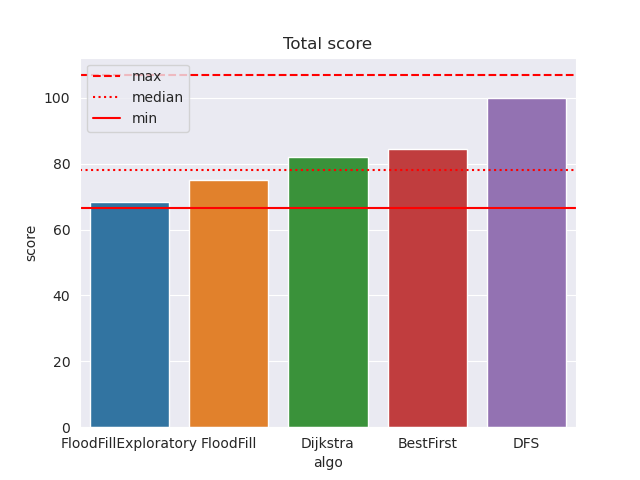

In [60]:
linestyles = {'max':'dashed', 'median':'dotted', 'min':'solid'}
col_title = {'explore': 'Exploration run', 'navigate':'Navigation run', 'score': 'Total score'}

for col, title in col_title.items():
    plt.figure()
    ax = sns.barplot(df_res, x=df_res.index, y=col)
    
    for line, style in linestyles.items():
        ax.axhline(y=df_metrics.loc[df_metrics.index == line][col].iloc[0], c='red', linestyle=style, label="horizontal")
    
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles = handles, labels = linestyles.keys(),loc='upper left')

    plt.title(title)
    plt.show()
    plt.savefig(f'images/agg_results_{col}.png')